In [1]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Useful funtions

In [2]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


Get Data

In [3]:
df = pd.read_csv("data/train.csv", sep = ";")
df


age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
0        unknown    5   may       261         1     -1         0  unknown   no  
1        unknown    5   may       151         1     -1         0  unknown   no  
2        unknown    5   may        76         1     -1         0  unknown   no  
3        unknown    5   may        92         1     -1         0  unknown   no  
4        unknown    5   may       198         1     -1         0  unknown   no  
...          ...  ...   ...       ...       ...    ...       ...      ...  ...  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no  

[45211 rows x 17 columns]

In [4]:
import pandas as pd  # dataframe manipulation
import numpy as np  # linear algebra
from sentence_transformers import SentenceTransformer
from dice_embeddings import DICE

dice = DICE(d = 20, min_bound=-10000, max_bound=150000, norm="l2")
df = pd.read_csv("data/train.csv", sep=";")

# from dice_embeddings import DICE
# import pandas as pd

# dice = DICE()

def get_numeric_embedding(x):
    
    embeddings = []
    
    for val in x:
        out = dice.make_dice(val)   
        embeddings.append(list(out))

    # make flat list
    embeddings = [item for sublist in embeddings for item in sublist]
    return embeddings


# def get_numeric_embedding(x):
    
#     embeddings = []
    
#     for val in x:
#         out = dice.make_dice(val)   
#         embeddings.append(list(out))

#     # make flat list
#     embeddings = [item for sublist in embeddings for item in sublist]
#     return embeddings
def compile_text(x):
    # text = f"""Age: {x['age']},  
    #             housing load: {x['housing']}, 
    #             Job: {x['job']}, 
    #             Marital: {x['marital']}, 
    #             Education: {x['education']}, 
    #             Default: {x['default']}, 
    #             Balance: {x['balance']}, 
    #             Personal loan: {x['loan']}
    #         """
    text = f""" Housing loan: {x['housing']}, 
                Job: {x['job']}, 
                Marital: {x['marital']}, 
                Education: {x['education']}, 
                Default: {x['default']}
            """
    return text

# def scale_number(num1, num2):
#     num1_scaled = (num1 - 0) / (100000 - 0)
#     num2_scaled = (num2 - 0) / (102127 - 0)
#     return list([num1_scaled, num2_scaled])

sentences = []

# df = df.iloc[:5, :]
model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")

out = pd.DataFrame()

for index, row in df.iterrows():

    
    sentence = compile_text(row)
    sentence_embedding = pd.DataFrame(model.encode(sentences=sentence, show_progress_bar=False, normalize_embeddings=True)).T
    numeric_embedding = pd.DataFrame(get_numeric_embedding([row['balance'], row['age']])).T
    
    complete_embedding_df = pd.concat([sentence_embedding, numeric_embedding], axis=1)
    
    out = pd.concat([out, complete_embedding_df], axis=0)
    
    # # write to csv after every 1000 rows
    # if index % 1000 == 0:
    #     out.to_csv('data/embeddings.csv', index=False)
    
    print(f"Finished row {index}")
    
    # sentences.append(compile_text(row))

# model = SentenceTransformer(r"sentence-transformers/all-roberta-large-v1")

# output = model.encode(sentences=sentences, show_progress_bar=True, normalize_embeddings=True)

out


Finished row 0
Finished row 1
Finished row 2
Finished row 3
Finished row 4
Finished row 5
Finished row 6
Finished row 7
Finished row 8
Finished row 9
Finished row 10
Finished row 11
Finished row 12
Finished row 13
Finished row 14
Finished row 15
Finished row 16
Finished row 17
Finished row 18
Finished row 19
Finished row 20
Finished row 21
Finished row 22
Finished row 23
Finished row 24
Finished row 25
Finished row 26
Finished row 27
Finished row 28
Finished row 29
Finished row 30
Finished row 31
Finished row 32
Finished row 33
Finished row 34
Finished row 35
Finished row 36
Finished row 37
Finished row 38
Finished row 39
Finished row 40
Finished row 41
Finished row 42
Finished row 43
Finished row 44
Finished row 45
Finished row 46
Finished row 47
Finished row 48
Finished row 49
Finished row 50
Finished row 51
Finished row 52
Finished row 53
Finished row 54
Finished row 55
Finished row 56
Finished row 57
Finished row 58
Finished row 59
Finished row 60
Finished row 61
Finished row 62
Fi

MemoryError: Unable to allocate 11.9 MiB for an array with shape (384, 8095) and data type float32

In [9]:
# df_embedding = pd.read_csv("./embedding_train.csv", sep = ",")
# df_embedding

df_embedding = out

In [10]:
# EDA
df_embedding.describe()

0             1             2             3             4   \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean       0.057956     -0.021889      0.029151      0.026249     -0.054832   
std        0.012116      0.014545      0.007337      0.007629      0.010541   
min        0.021610     -0.073970     -0.000320      0.005635     -0.085528   
25%        0.051555     -0.032824      0.024866      0.021033     -0.062602   
50%        0.054017     -0.022720      0.027081      0.025298     -0.054144   
75%        0.067891     -0.009198      0.034678      0.029704     -0.046851   
max        0.098691      0.009977      0.056437      0.055338     -0.020264   

                 5             6             7             8             9   \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean       0.003358     -0.095779     -0.031583     -0.058551      0.003644   
std        0.014036      0.012694      0.010725      0.011131      0.011177   
min       -0.024445     -0.133337     -0.070912     -0.085542     -0.033005   
25%       -0.007184     -0.104827     -0.040040     -0.064630     -0.006002   
50%        0.001657     -0.096831     -0.030456     -0.060289      0.008619   
75%        0.012330     -0.084926     -0.024817     -0.049565      0.011867   
max        0.033688     -0.062464     -0.005125     -0.028087      0.020913   

       ...            30            31            32            33  \
count  ...  45211.000000  45211.000000  45211.000000  45211.000000   
mean   ...     -0.198042      0.090939      0.158068      0.199850   
std    ...      0.000016      0.000081      0.000043      0.000042   
min    ...     -0.198076      0.090528      0.157848      0.199759   
25%    ...     -0.198054      0.090885      0.158039      0.199818   
50%    ...     -0.198045      0.090953      0.158075      0.199842   
75%    ...     -0.198031      0.090999      0.158100      0.199878   
max    ...     -0.197961      0.091113      0.158161      0.200064   

                 34            35            36            37            38  \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean      -0.106053     -0.077539     -0.152104     -0.442738      0.049495   
std        0.000031      0.000068      0.000013      0.000002      0.000043   
min       -0.106211     -0.077686     -0.152172     -0.442749      0.049402   
25%       -0.106073     -0.077590     -0.152113     -0.442740      0.049463   
50%       -0.106047     -0.077551     -0.152102     -0.442738      0.049487   
75%       -0.106029     -0.077494     -0.152094     -0.442737      0.049524   
max       -0.105985     -0.077193     -0.152076     -0.442733      0.049716   

                 39  
count  45211.000000  
mean       0.248463  
std        0.000037  
min        0.248273  
25%        0.248438  
50%        0.248470  
75%        0.248491  
max        0.248543  

[8 rows x 424 columns]



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



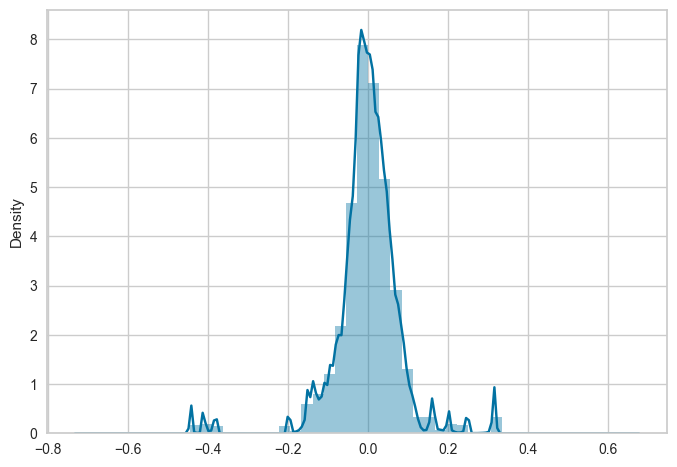

In [11]:
# plot distribution of embedding
sns.distplot(df_embedding)
plt.show()

Outliers



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



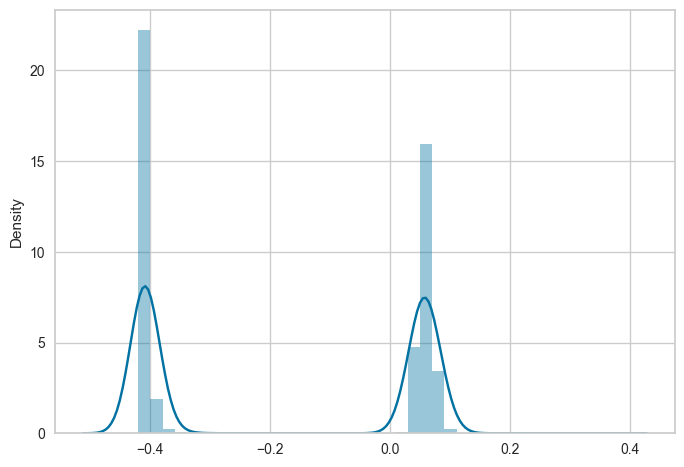

In [14]:
# plot distribution of embedding
sns.distplot(df_embedding[0])
plt.show()

In [15]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

clf = ECOD()
clf.fit(df_embedding)


out = clf.predict(df_embedding) 
df_embedding["outliers"] = out
df["outliers"] = out

df_embedding_no_out = df_embedding[df_embedding["outliers"] == 0]
df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)


df_embedding_with_out = df_embedding.copy()
df_embedding_with_out = df_embedding_with_out.drop(["outliers"], axis = 1)

In [37]:
df_no_out = df[df["outliers"] == 0]
df_no_out = df_no_out.drop(["outliers"], axis = 1)
df_no_out

age           job  marital  education default  balance housing loan  \
0       58    management  married   tertiary      no     2143     yes   no   
1       44    technician   single  secondary      no       29     yes   no   
3       47   blue-collar  married    unknown      no     1506     yes   no   
5       35    management  married   tertiary      no      231     yes   no   
6       28    management   single   tertiary      no      447     yes  yes   
...    ...           ...      ...        ...     ...      ...     ...  ...   
45205   25    technician   single  secondary      no      505      no  yes   
45206   51    technician  married   tertiary      no      825      no   no   
45208   72       retired  married  secondary      no     5715      no   no   
45209   57   blue-collar  married  secondary      no      668      no   no   
45210   37  entrepreneur  married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
0        unknown    5   may       261         1     -1         0  unknown   no  
1        unknown    5   may       151         1     -1         0  unknown   no  
3        unknown    5   may        92         1     -1         0  unknown   no  
5        unknown    5   may       139         1     -1         0  unknown   no  
6        unknown    5   may       217         1     -1         0  unknown   no  
...          ...  ...   ...       ...       ...    ...       ...      ...  ...  
45205   cellular   17   nov       386         2     -1         0  unknown  yes  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no  

[40692 rows x 17 columns]

In [16]:
df_embedding_no_out.shape

(40692, 424)

In [17]:
df_embedding_with_out.shape

(45211, 424)

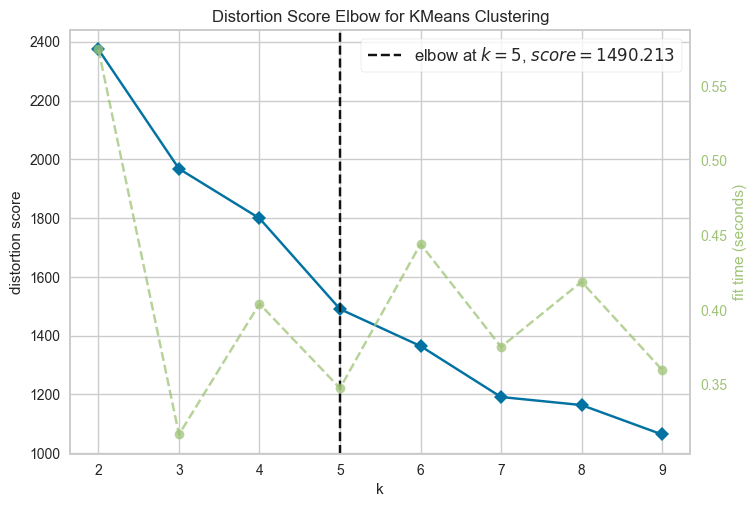

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=True)
 
visualizer.fit(df_embedding_with_out)        # Fit the data to the visualizer
visualizer.show()       

Best Number of Clusters

In [19]:
# def make_Silhouette_plot(X, n_clusters):
#     plt.xlim([-0.1, 1])
#     plt.ylim([0, len(X) + (n_clusters + 1) * 10])
#     clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
#     cluster_labels = clusterer.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =", n_clusters,
#         "The average silhouette_score is :", silhouette_avg,
#     )
# # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)
#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         plt.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10
#         plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
#         plt.xlabel("The silhouette coefficient values", fontsize=24)
#         plt.ylabel("Cluster label", fontsize=24)
#         plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#         plt.yticks([])  
#         plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# range_n_clusters = list(range(2,10))
# for n_clusters in range_n_clusters:
#     print(f"N cluster: {n_clusters}")
#     make_Silhouette_plot(df_embedding_no_out, n_clusters)   
#     plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
#     plt.close()

![Alt text](kpropotype_no_out.png)

The best number is 5-6

Modeling

In [20]:
n_clusters = 4

In [21]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(df_embedding_no_out)
print(clusters.inertia_)
clusters_predict = clusters.predict(df_embedding_no_out)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


1175.0988269718976


Evaluation

In [22]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(df_embedding_no_out,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(df_embedding_no_out,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_out,clusters_predict)}")

Davies bouldin score: 1.6748323729666934
Calinski Score: 9765.798367143932
Silhouette Score: 0.28583897825509985


In [23]:
df_embedding_no_out

0         1         2         3         4         5         6   \
0   0.070691 -0.024291  0.021448  0.024576 -0.050735 -0.000008 -0.112558   
0   0.049612 -0.024722  0.024426  0.025298 -0.074871 -0.020314 -0.072445   
0   0.041388 -0.037216  0.027541  0.019617 -0.051859  0.023432 -0.100825   
0   0.070691 -0.024291  0.021448  0.024576 -0.050735 -0.000008 -0.112558   
0   0.067891 -0.020523  0.020824  0.025024 -0.050414 -0.008134 -0.091215   
..       ...       ...       ...       ...       ...       ...       ...   
0   0.047291 -0.008585  0.034971  0.026983 -0.066041 -0.017818 -0.067380   
0   0.064341 -0.009464  0.035023  0.021558 -0.065011 -0.007002 -0.096069   
0   0.064263  0.007266  0.033650  0.033142 -0.044423  0.009526 -0.115068   
0   0.052894 -0.022410  0.036111  0.021996 -0.049131  0.024782 -0.095854   
0   0.076486 -0.014036  0.017606  0.018109 -0.048015  0.000921 -0.091886   

          7         8         9   ...        30        31        32        33  \
0  -0.037328 -0.044452  0.009408  ... -0.198016  0.090809  0.157998  0.199917   
0  -0.021263 -0.077605 -0.016649  ... -0.198037  0.090915  0.158055  0.199862   
0  -0.028768 -0.058905  0.011837  ... -0.198033  0.090893  0.158043  0.199874   
0  -0.037328 -0.044452  0.009408  ... -0.198051  0.090984  0.158092  0.199826   
0  -0.046520 -0.060289 -0.010729  ... -0.198061  0.091037  0.158120  0.199799   
..       ...       ...       ...  ...       ...       ...       ...       ...   
0  -0.024633 -0.075219 -0.009920  ... -0.198066  0.091060  0.158132  0.199787   
0  -0.023917 -0.050682  0.006712  ... -0.198027  0.090862  0.158027  0.199890   
0  -0.026501 -0.065680  0.016098  ... -0.197995  0.090703  0.157941  0.199973   
0  -0.033078 -0.064431  0.014331  ... -0.198018  0.090817  0.158002  0.199913   
0  -0.024119 -0.062377  0.003691  ... -0.198048  0.090968  0.158084  0.199834   

          34        35        36        37        38        39  
0  -0.106103 -0.077430 -0.152126 -0.442742  0.049565  0.248403  
0  -0.106062 -0.077519 -0.152108 -0.442739  0.049508  0.248452  
0  -0.106070 -0.077500 -0.152112 -0.442740  0.049520  0.248441  
0  -0.106035 -0.077577 -0.152097 -0.442737  0.049471  0.248484  
0  -0.106015 -0.077622 -0.152088 -0.442735  0.049443  0.248508  
..       ...       ...       ...       ...       ...       ...  
0  -0.106006 -0.077641 -0.152084 -0.442735  0.049430  0.248519  
0  -0.106082 -0.077475 -0.152117 -0.442740  0.049536  0.248427  
0  -0.106144 -0.077340 -0.152143 -0.442745  0.049622  0.248354  
0  -0.106100 -0.077436 -0.152125 -0.442742  0.049561  0.248406  
0  -0.106041 -0.077564 -0.152099 -0.442737  0.049479  0.248477  

[40692 rows x 424 columns]

In [28]:
len(np.unique(clusters_predict))

4

In [31]:
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_no_out, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=0.8, width_line = 0.1)



ValueError: Length of values (504) does not match length of index (424)

![Alt text](img/embedding1.png)

In [32]:
pca_2d_object, df_pca_2d = get_pca_2d(df_embedding_no_out, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)


ValueError: Length of values (504) does not match length of index (424)

![Alt text](img/embedding2.png)

t-SNE   3D

In [33]:
sampling_data = df_embedding_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)


KeyboardInterrupt: 

![Alt text](img/embedding3.png)

In [ ]:
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=0.1, width_line = 0.1)

t-SNE 2D

In [ ]:
df_tsne_2d = TSNE(
                  n_components=2, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=0.5, width_line = 0.5)


![Alt text](img/embedding4.png)

In [ ]:
plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)


<h1> Explanations </h1>

In [ ]:
df

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  \
0        unknown    5   may       261         1     -1         0  unknown   
1        unknown    5   may       151         1     -1         0  unknown   
2        unknown    5   may        76         1     -1         0  unknown   
3        unknown    5   may        92         1     -1         0  unknown   
4        unknown    5   may       198         1     -1         0  unknown   
...          ...  ...   ...       ...       ...    ...       ...      ...   
45206   cellular   17   nov       977         3     -1         0  unknown   
45207   cellular   17   nov       456         2     -1         0  unknown   
45208   cellular   17   nov      1127         5    184         3  success   
45209  telephone   17   nov       508         4     -1         0  unknown   
45210   cellular   17   nov       361         2    188        11    other   

         y  outliers  
0       no         0  
1       no         0  
2       no         1  
3       no         0  
4       no         1  
...    ...       ...  
45206  yes         0  
45207  yes         0  
45208  yes         0  
45209   no         0  
45210   no         1  

[45211 rows x 18 columns]

In [ ]:
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop("outliers", axis = 1)

In [ ]:
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers[col] = df_no_outliers[col].astype('category')

clf_km.fit(X = df_no_outliers , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: contact: object, month: object, poutcome: object, y: object

In [ ]:
y_pred = clf_km.predict(df_no_outliers)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5274
           1       1.00      1.00      1.00      2172
           2       1.00      1.00      1.00      1896
           3       1.00      1.00      1.00      2939
           4       1.00      1.00      1.00      5719

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000



Cluster Info

In [35]:
df_no_outliers

NameError: name 'df_no_outliers' is not defined

In [38]:
df_no_outliers = df_no_out

In [42]:
df_no_outliers["cluster"] = clusters_predict

df_group = df_no_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
        
    }
).sort_values("job").reset_index()
df_group

cluster          job  marital  education housing loan        age  \
0        2  blue-collar  married  secondary     yes   no  40.146167   
1        1   management   single  secondary     yes   no  34.081613   
2        3   management  married   tertiary      no   no  45.302580   
3        0   technician  married  secondary     yes   no  41.822288   

       balance default  
0  1082.506213      no  
1  1285.718217      no  
2  1589.745713      no  
3  1205.822905      no